In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from prompt_toolkit.key_binding.bindings.named_commands import yank_nth_arg

In [59]:
# Аппроксимируемая функция
def target_function(x, with_error = False):
    y = 2*x**3+3*x**2-5*x+4 #np.sin(x)
    if with_error:
        return y + np.random.random(x.shape) * 0.1 - 0.05
    else:
        return y

In [60]:
# Подготовка данных
x_min, x_max = -2 * np.pi, 2 * np.pi
num_points = 100
x_data = np.linspace(x_min, x_max, num_points).reshape(-1, 1)
y_data = target_function(x_data, True)

In [61]:
# Архитектура сети
input_size = 1
hidden_size = 30
output_size = 1

In [62]:
# Инициализация весов
torch.manual_seed(42)
W1 = torch.randn(input_size, hidden_size, requires_grad=False) * 0.5
b1 = torch.zeros(1, hidden_size, requires_grad=False)
W2 = torch.randn(hidden_size, output_size, requires_grad=False) * 0.5
b2 = torch.zeros(1, output_size, requires_grad=False)

X = torch.tensor(x_data, dtype = torch.float32)
Y = torch.tensor(y_data, dtype = torch.float32)

In [63]:
# Функция активации
def activation(x):
    x = torch.clamp(x, -500, 500)
    return 1 / (1 + torch.exp(-x))

# Производная функции активации
def activation_derivative(x):
    return x * (1 - x)

In [64]:
# Нормализация
def norm(x):
    x_min = torch.min(x)
    x_max = torch.max(x)
    xn = (x - x_min)/(x_max - x_min)
    return xn, x_min, x_max

# Денормализация
def denorm(x, x_min, x_max):
    xd = x * (x_max - x_min) + x_min
    return xd

In [65]:
# Прямое распространение
def predict(X, W1, b1, W2, b2):
    z1 = torch.mm(X, W1) + b1
    a1 = activation(z1)
    z2 = torch.mm(a1, W2) + b2
    y_pred = z2
    return z1, a1, z2, y_pred

In [66]:
# Обратное распространение ошибки
def backward(X, Y, z1, a1, z2, y_pred, W2):
    m = X.size(0)
    dZ2 = y_pred - Y
    dW2 = torch.mm(a1.t(), dZ2) / m
    db2 = torch.sum(dZ2, dim = 0, keepdim=True) / m

    dA1 = torch.mm(dZ2, W2.t())
    dZ1 = dA1 * activation_derivative(a1)

    dW1 = torch.mm(X.t(), dZ1) / m
    db1 = torch.sum(dZ1, dim = 0, keepdim=True) / m

    return dW1, db1, dW2, db2


In [67]:
# Обновление весов
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    with torch.no_grad():
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [68]:
# Гиперпараметры сети
learning_rate = 0.25
epochs = 100000

In [69]:
# Вычисление функции потерь
def compute_loss(y_pred, Y):
    return torch.mean((y_pred - Y) ** 2)

In [70]:
# Обучение
def train(X, Y, W1, b1, W2, b2, learning_rate, epochs):
    losses = []
    for epoch in range(epochs):
        # Прямое распространение
        z1, a1, z2, y_pred = predict(X, W1, b1, W2, b2)

        # Вычисление функции потерь
        loss = compute_loss(y_pred, Y)
        losses.append(loss.item())

        # Обратное распространение
        dW1, db1, dW2, db2 = backward(X, Y, z1, a1, z2, y_pred, W2)

        # Обновление параметров
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Вывод информации об "образовательном процессе"
        if epoch % 200 == 0:
            print(f"Epoch {epoch}: loss {loss.item():.6f}")

    return W1, b1, W2, b2, losses

Epoch 0: loss 3.770407
Epoch 200: loss 0.001709
Epoch 400: loss 0.001338
Epoch 600: loss 0.001109
Epoch 800: loss 0.000934
Epoch 1000: loss 0.000801
Epoch 1200: loss 0.000698
Epoch 1400: loss 0.000617
Epoch 1600: loss 0.000553
Epoch 1800: loss 0.000501
Epoch 2000: loss 0.000458
Epoch 2200: loss 0.000422
Epoch 2400: loss 0.000391
Epoch 2600: loss 0.000365
Epoch 2800: loss 0.000342
Epoch 3000: loss 0.000322
Epoch 3200: loss 0.000304
Epoch 3400: loss 0.000289
Epoch 3600: loss 0.000276
Epoch 3800: loss 0.000264
Epoch 4000: loss 0.000253
Epoch 4200: loss 0.000243
Epoch 4400: loss 0.000235
Epoch 4600: loss 0.000227
Epoch 4800: loss 0.000220
Epoch 5000: loss 0.000214
Epoch 5200: loss 0.000209
Epoch 5400: loss 0.000204
Epoch 5600: loss 0.000199
Epoch 5800: loss 0.000195
Epoch 6000: loss 0.000191
Epoch 6200: loss 0.000188
Epoch 6400: loss 0.000185
Epoch 6600: loss 0.000182
Epoch 6800: loss 0.000179
Epoch 7000: loss 0.000177
Epoch 7200: loss 0.000174
Epoch 7400: loss 0.000172
Epoch 7600: loss 0.

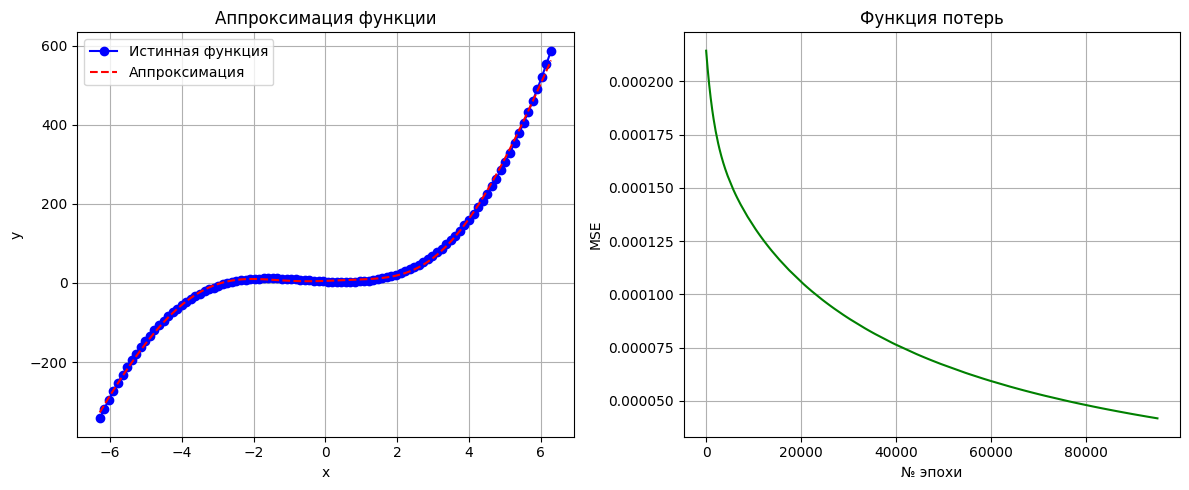


Финальная ошибка (MSE): 36.141010


In [71]:
yn, y_min, y_max = norm(Y)
W1, b1, W2, b2, losses = train(X, yn, W1, b1, W2, b2, learning_rate, epochs)

with torch.no_grad():
    _, _, _, y_pred = predict(X, W1, b1, W2, b2)

y_pred = denorm(y_pred, y_min, y_max)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_data, y_data, label = "Истинная функция", color = "blue", marker = "o")
plt.plot(x_data, y_pred.numpy(), label = "Аппроксимация", color = "red", linestyle = "--")
plt.legend()
plt.grid(True)
plt.title("Аппроксимация функции")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 2, 2)
plt.plot(losses[5000:], color = "green")
plt.title("Функция потерь")
plt.xlabel("№ эпохи")
plt.ylabel("MSE")
plt.grid(True)

plt.tight_layout()
plt.show()

final_loss = compute_loss(y_pred, Y)
print(f"\nФинальная ошибка (MSE): {final_loss.item():.6f}")